In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data_source import YahooFinanceDataSource

data_source = YahooFinanceDataSource()
holdings_df = data_source.read_spy_holdings('holdings-daily-us-en-spy.xlsx')
print(f"Found {len(holdings_df)} constituent stocks in SPY ETF.")
end_date = '2025-01-01'  
start_date = '2025-02-15'  
# replace holdings_df ticker BRK.B with BRK-B and BF.B with BF-B, and '-' with USD
holdings_df['Ticker'] = holdings_df['Ticker'].replace({
    'BRK.B': 'BRK-B',
    'BF.B': 'BF-B',
    '-': 'USD'
})
tickers = ['SPY'] + holdings_df['Ticker'].tolist()
print(f"Fetching historical data for SPY and {len(tickers)-1} constituents...")


Found 505 constituent stocks in SPY ETF.
Fetching historical data for SPY and 505 constituents...


In [3]:
price_data = data_source.get_historical_data(tickers, start_date, end_date)
if 'SPY' not in price_data.columns:
    print("Error: SPY data not found in the downloaded data.")
spy_data = price_data['SPY'].copy()
valid_columns = list(price_data.columns[price_data.isna().sum() == 0])

if 'SPY' not in valid_columns and 'SPY' in price_data.columns:
    valid_columns.append('SPY')

price_data = price_data[valid_columns]

valid_constituents = [ticker for ticker in valid_columns if ticker != 'SPY']
print(f"Found valid data for {len(valid_constituents)} out of {len(holdings_df)} constituents.")

print("Calculating weighted portfolio from constituents...")
weighted_portfolio = data_source.calculate_weighted_portfolio(holdings_df, price_data)

print("Verifying SPY returns against weighted constituent returns...")
verification_results = data_source.verify_spy_vs_constituents(
    spy_data,  
    weighted_portfolio, 
    threshold=0.01
)

status = "PASSED" if verification_results['within_threshold'] else "FAILED"
print(f"\nVerification {status}")
print(f"Maximum difference: {verification_results['max_difference']*100:.4f}%")
print(f"Mean difference: {verification_results['mean_difference']*100:.4f}%")
print(f"Spearman Coefficient: {verification_results['spearman_coeff']*100:.4f}%")

TypeError: download() got an unexpected keyword argument 'parallel'

In [ ]:
def plot_comparison(spy_returns: pd.Series, portfolio_returns: pd.Series, title: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(spy_returns.index, spy_returns, label='SPY', color='blue')
    ax1.plot(portfolio_returns.index, portfolio_returns, label='Weighted Portfolio', color='orange')
    ax1.set_title(f"{title} - Daily")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Return')
    ax1.legend()
    ax1.grid(True)
    
    cum_spy = (1 + spy_returns).cumprod()
    cum_portfolio = (1 + portfolio_returns).cumprod()
    
    ax2.plot(cum_spy.index, cum_spy, label='SPY', color='blue')
    ax2.plot(cum_portfolio.index, cum_portfolio, label='Weighted Portfolio', color='orange')
    ax2.set_title(f"{title} - Cumulative")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('spy_verification_results.png')
    print("Saved comparison plot to 'spy_verification_results.png'")


Saved comparison plot to 'spy_verification_results.png'


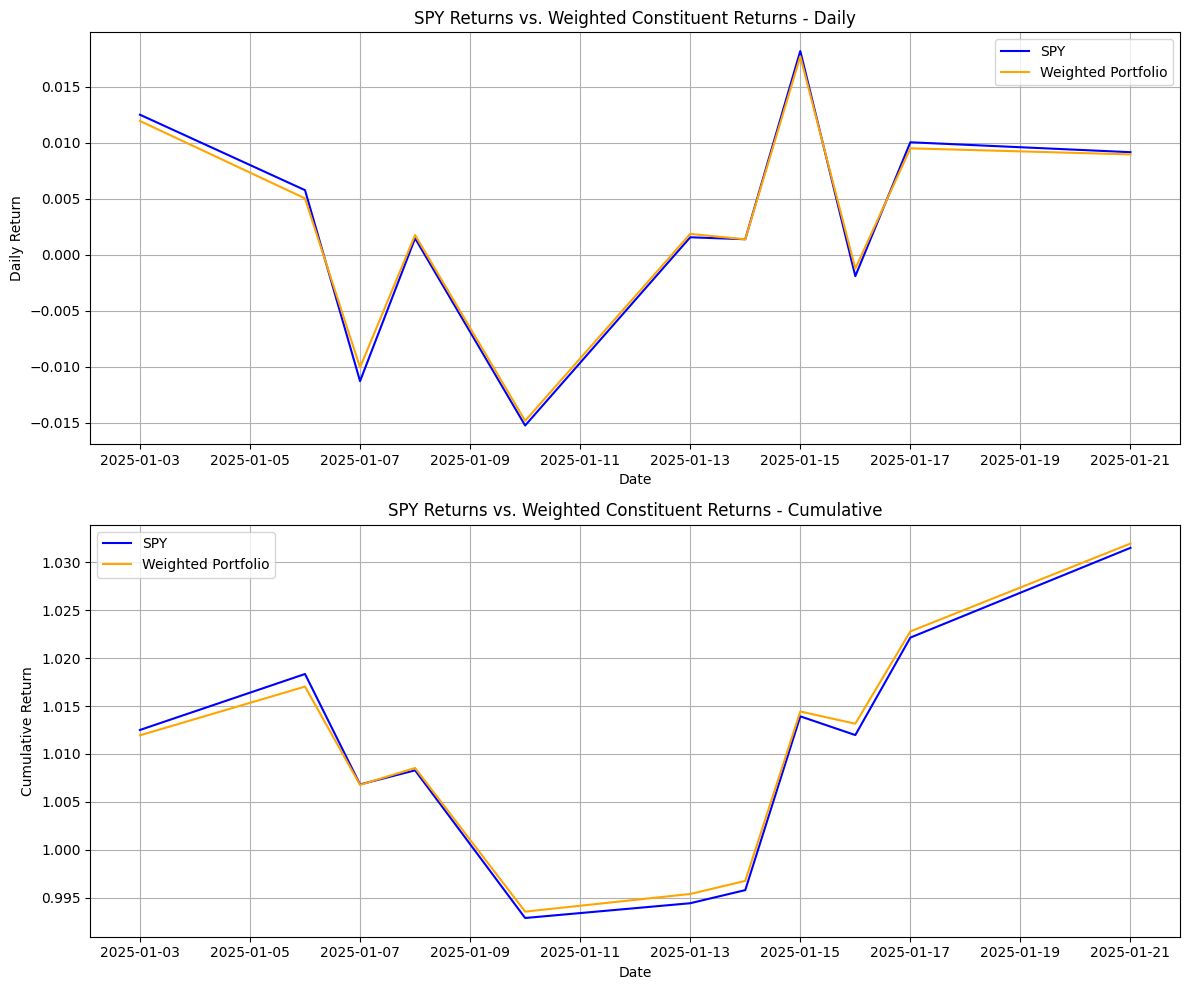

In [ ]:
plot_comparison(
    verification_results['spy_returns'], 
    verification_results['portfolio_returns'],
    'SPY Returns vs. Weighted Constituent Returns'
)

In [ ]:
from data_source import YahooFinanceDataSource
from order_generator import OrderGenerator
from metrics import ExtendedMetrics
from backtest_engine import EquityBacktestEngine 
import pandas as pd
import matplotlib.pyplot as plt

class WeightedOrderGenerator(OrderGenerator):
    """
    Uses holdings weights for order sizing.
    For each ticker from holdings_df (excluding SPY), a BUY is generated on the common start date 
    and a SELL on the common end date.
    The order quantity is computed as:
         quantity = (initial_cash * normalized_weight) / price_on_common_start
    using float arithmetic to preserve exposure.
    """
    def __init__(self, holdings_df: pd.DataFrame, initial_cash: float):
        self.holdings_df = holdings_df.copy()
        self.initial_cash = initial_cash
        total_weight = self.holdings_df['Weight'].sum()
        self.holdings_df['NormalizedWeight'] = self.holdings_df['Weight'] / total_weight
        
    def generate_orders(self, price_data: pd.DataFrame) -> list:
        orders = []
        # Use common start and end dates for all tickers
        common_start = price_data.index[0]
        common_end = price_data.index[-1]
        for ticker in self.holdings_df['Ticker']:
            if ticker not in price_data.columns:
                continue
            # Since price_data has been filtered for valid columns, every ticker has data on common_start
            first_price = price_data.at[common_start, ticker]
            norm_weight = self.holdings_df.loc[self.holdings_df['Ticker'] == ticker, 'NormalizedWeight'].iloc[0]
            allocated_cash = self.initial_cash * norm_weight
            quantity = allocated_cash / first_price
            if quantity <= 0:
                continue
            orders.append({
                "date": common_start,
                "type": "BUY",
                "ticker": ticker,
                "quantity": quantity
            })
            orders.append({
                "date": common_end,
                "type": "SELL",
                "ticker": ticker,
                "quantity": quantity
            })
        return sorted(orders, key=lambda o: o["date"])


class SimpleOrderGenerator(OrderGenerator):
    """
    Creates two orders (BUY then SELL) for each ticker in the provided data.
    For SPY-only strategy, the quantity is computed as the full allocation:
         quantity = initial_cash / price_on_common_start
    using float arithmetic.
    """
    def generate_orders(self, data: pd.DataFrame) -> list:
        orders = []
        common_start = data.index[0]
        common_end = data.index[-1]
        for ticker in data.columns:
            series = data[ticker].dropna()
            if series.empty:
                continue
            first_price = data.at[common_start, ticker]
            quantity = 100_000 / first_price  # using full initial cash
            orders.append({
                "date": common_start,
                "type": "BUY",
                "ticker": ticker,
                "quantity": quantity
            })
            orders.append({
                "date": common_end,
                "type": "SELL",
                "ticker": ticker,
                "quantity": quantity
            })
        return sorted(orders, key=lambda o: o["date"])

In [ ]:
data_source = YahooFinanceDataSource()
holdings_file = 'holdings-daily-us-en-spy.xlsx'
holdings_df = data_source.read_spy_holdings(holdings_file)
print(f"Found {len(holdings_df)} constituent stocks in SPY ETF.")
holdings_df['Ticker'] = holdings_df['Ticker'].replace({
    'BRK.B': 'BRK-B',
    'BF.B': 'BF-B',
    '-': 'USD'
})
tickers = ['SPY'] + holdings_df['Ticker'].tolist()
print(f"Fetching historical data for SPY and {len(tickers)-1} constituents...")

start_date = '2025-01-02'
end_date = '2025-01-22'
price_data = data_source.get_historical_data(tickers, start_date, end_date)


valid_columns = list(price_data.columns[price_data.isna().sum() == 0])
if 'SPY' not in valid_columns and 'SPY' in price_data.columns:
    valid_columns.append('SPY')
price_data = price_data[valid_columns]


initial_cash = 100_000

# Generate weighted orders for holdings tickers using the normalized weights
weighted_og = WeightedOrderGenerator(holdings_df, initial_cash)
orders_weighted = weighted_og.generate_orders(price_data)
print(f"Generated {len(orders_weighted)} weighted orders for holdings tickers.")

# Generate simple orders for SPY-only strategy
price_data_spy = price_data[['SPY']].copy()
simple_og = SimpleOrderGenerator()
orders_spy = simple_og.generate_orders(price_data_spy)
print(f"Generated {len(orders_spy)} orders for SPY only.")

[                       1%                       ]  3 of 506 completed

Found 505 constituent stocks in SPY ETF.
Fetching historical data for SPY and 505 constituents...


[*********************100%***********************]  506 of 506 completed

1 Failed download:
['SNDK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-02 -> 2025-01-22) (Yahoo error = "Data doesn\'t exist for startDate = 1735794000, endDate = 1737522000")')


Generated 1008 weighted orders for holdings tickers.
Generated 2 orders for SPY only.


In [ ]:
engine = EquityBacktestEngine(initial_cash=initial_cash)

backtest_result_weighted = engine.run_backtest(orders_weighted, price_data)
portfolio_weighted = backtest_result_weighted['portfolio_values']
returns_weighted = portfolio_weighted['Portfolio Value'].pct_change().dropna()

backtest_result_spy = engine.run_backtest(orders_spy, price_data_spy)
portfolio_spy = backtest_result_spy['portfolio_values']
returns_spy = portfolio_spy['Portfolio Value'].pct_change().dropna()

common_index = returns_weighted.index.intersection(returns_spy.index)
returns_weighted_aligned = returns_weighted.loc[common_index]
returns_spy_aligned = returns_spy.loc[common_index]

returns_df = pd.DataFrame({
    'Weighted Holdings': returns_weighted_aligned,
    'SPY Only': returns_spy_aligned
})

# print final vals of returns
print(f"Final value of Weighted Holdings: {portfolio_weighted['Portfolio Value'].iloc[-1]:.2f}")
print(f"Final value of SPY Only: {portfolio_spy['Portfolio Value'].iloc[-1]:.2f}")

2025-01-02 00:00:00: Portfolio Value - 100000.00
2025-01-03 00:00:00: Portfolio Value - 101194.29
2025-01-06 00:00:00: Portfolio Value - 101702.51
2025-01-07 00:00:00: Portfolio Value - 100677.87
2025-01-08 00:00:00: Portfolio Value - 100853.89
2025-01-10 00:00:00: Portfolio Value - 99356.61
2025-01-13 00:00:00: Portfolio Value - 99540.71
2025-01-14 00:00:00: Portfolio Value - 99676.85
2025-01-15 00:00:00: Portfolio Value - 101442.85
2025-01-16 00:00:00: Portfolio Value - 101315.51
2025-01-17 00:00:00: Portfolio Value - 102277.72
2025-01-21 00:00:00: Portfolio Value - 103193.58
2025-01-02 00:00:00: Portfolio Value - 100000.00
2025-01-03 00:00:00: Portfolio Value - 101250.34
2025-01-06 00:00:00: Portfolio Value - 101833.60
2025-01-07 00:00:00: Portfolio Value - 100682.47
2025-01-08 00:00:00: Portfolio Value - 100829.57
2025-01-10 00:00:00: Portfolio Value - 99290.16
2025-01-13 00:00:00: Portfolio Value - 99444.10
2025-01-14 00:00:00: Portfolio Value - 99580.94
2025-01-15 00:00:00: Portf


Spearman Correlation between weighted holdings and SPY-only daily returns:
  100.0000%
Standard Deviation of the difference in daily returns:
 Weighted Holdings    0.009441
SPY Only             0.009928
dtype: float64

Saved cumulative returns plot as 'weighted_vs_spy_cumulative_returns.png'


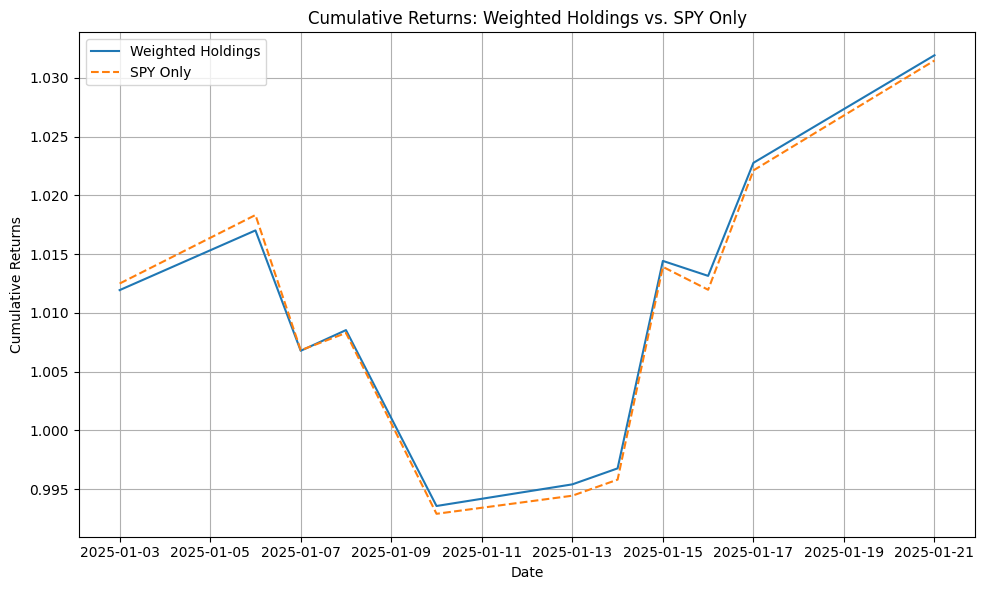

In [ ]:
spearman_corr = returns_df.corr(method='spearman').iloc[0, 1]
print(f"\nSpearman Correlation between weighted holdings and SPY-only daily returns:")
print(f"  {spearman_corr*100:.4f}%")
# print standard deviation between Weighted Holdings and SPY Only
standard_deviation = returns_df.std()
print(f"Standard Deviation of the difference in daily returns:\n {standard_deviation}")

cum_returns_weighted = (1 + returns_weighted_aligned).cumprod()
cum_returns_spy = (1 + returns_spy_aligned).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum_returns_weighted.index, cum_returns_weighted, label='Weighted Holdings')
plt.plot(cum_returns_spy.index, cum_returns_spy, label='SPY Only', linestyle='--')
plt.title('Cumulative Returns: Weighted Holdings vs. SPY Only')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("weighted_vs_spy_cumulative_returns.png")
print("\nSaved cumulative returns plot as 'weighted_vs_spy_cumulative_returns.png'")
plt.show()

#### Drawbacks of the Current Backtest (BT) in the Notebook
- No slippage/transaction costs
- Survivorship bias (we're only modeling stocks in S&P who have technically 'survived' until this period in time)
- If not careful with shifts, can introduce look-ahead bias
- No liquidity constraints on our positions 

#### How To Improve Signal Construction and Backtesting
- Out of sample testing
- Sensitivity tests for params of our model (for example, how sensitive is mom. to window size??)
- Add smoothing for noise if testing on noisy data
- Ensure stationarity of our data before testing
- Kalman filter potentially to remove noisy data
- Implement a way to run factor decomposition on our implementations
- Implement a correlation calculator for multiple factors in our backtest engine